In [31]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Load data
df = pd.read_csv('traffic_accidents.csv')

In [21]:
# Clean and format
df.columns = df.columns.str.strip()
cat_cols = ['Location', 'Weather_Condition', 'Road_Condition', 'Light_Condition', 'Vehicle_Type']
df[cat_cols] = df[cat_cols].astype(str).apply(lambda col: col.str.strip().str.lower())
df['Severity'] = df['Severity'].str.strip().str.capitalize()


In [23]:
# Drop invalid rows
df = df[(df['Speed_kmph'] > 0) & (df['Age_of_Driver'] > 0)]

# Encode target
le = LabelEncoder()
df['Severity_Label'] = le.fit_transform(df['Severity'])

In [25]:
# Features and target
X = df.drop(['Accident_ID', 'Severity', 'Severity_Label'], axis=1)
y = df['Severity_Label']


In [33]:
# Preprocessing pipeline
numeric_features = ['Speed_kmph', 'Age_of_Driver']
categorical_features = ['Location', 'Weather_Condition', 'Road_Condition', 'Light_Condition', 'Vehicle_Type']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [35]:
# Model pipeline
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Speed_kmph',
                                                   'Age_of_Driver']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Location',
                                                   'Weather_Condition',
                                                   'Road_Condition',
                                                   'Light_Condition',
                                                   'Vehicle_Type'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [39]:
# Get feature importances
model = clf_pipeline.named_steps['classifier']
ohe = clf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
ohe_features = ohe.get_feature_names_out(categorical_features)
all_features = numeric_features + list(ohe_features)

importances = model.feature_importances_
imp_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=False).head(10)

C:\Users\hasha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hasha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hasha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


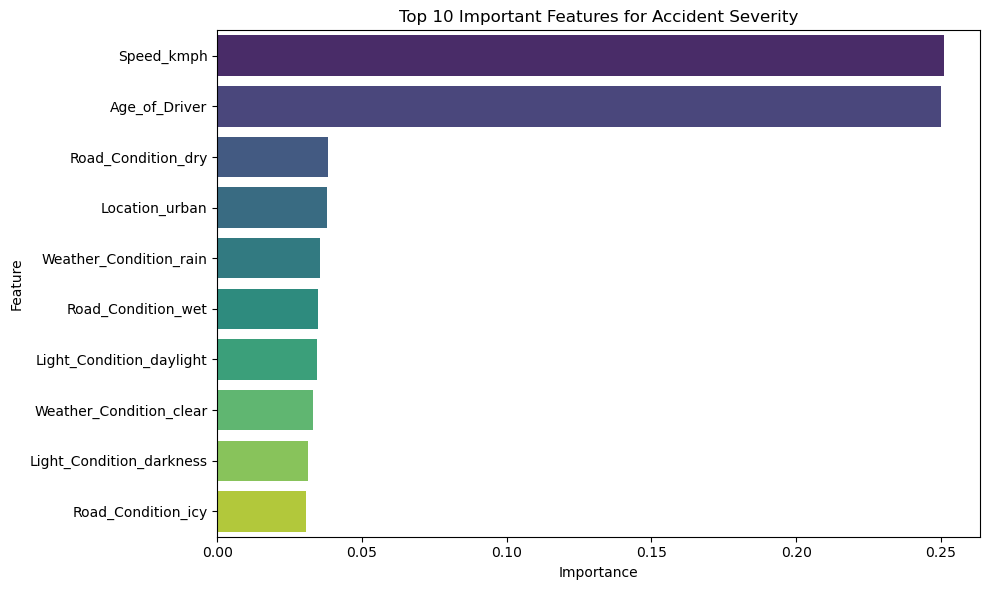

In [41]:
# Plot top 10
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=imp_df, palette='viridis')
plt.title('Top 10 Important Features for Accident Severity')
plt.tight_layout()
plt.show()